In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
#import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
#import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
#gene set enrichment analysis
#from gprofiler import GProfiler
#R interface
#import rpy2.rinterface_lib.callbacks
import logging

#from rpy2.robjects import pandas2ri
#import anndata2ri


In [2]:

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots. You can set the context as well to 'talk' or 'paper'.

In [3]:
sb.set_context(context='poster')


Load differential expression package 'diffxpy'.

In [4]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)
from batchglm.pkg_constants import TF_CONFIG_PROTO

batchglm version v0.7.4
diffpy version v0.7.4


In [5]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

# Introduction

The dataset consists of 12 samples from 3mm2 blocks that were manually dissected from the substantia nigra and cortex of 5 control (4 males & 1 female) de-identified post-mortem human donors,  including 2 substantia nigra (SN) replicates and sequenced using the 10X chromium system (V2) (GEO accession ID: [GSE140231](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140231)).

In this notebook, we are going to perform differential expression tests using the tool `diffxpy`. Further reading on `diffxpy` and its usage can be found on the (diffxpy github page)[https://github.com/theislab/diffxpy/] and the (tutorial page)[https://github.com/theislab/diffxpy_tutorials/]. This notebook builds upon these tutorials.  

Differential expression analysis is a group of statistical tests that are used to establish whether there a exists a significant variation across a set of tested conditions for each gene. In its easiset form, this test can test for the difference between two distinct groups: This scenario can be handled with (Welch's) T-test, rank sum tests or Wald and likelihood ratio tests (LRT). Wald tests and LRT allow for more adaptive assumptions on the noise model and can therefore be more statistically correct. Moreover, they also allow the testing of more complex effect, e.g. for the variation across many groups (a single p-value for: Is there any difference between four conditions?) or across continuous covariates (a single covariate for: Is a gene expression trajectory in time non-constant?). Below, we introduce these and similar scenarios. We dedicated separate tutorials to a selection of scenarios that require a longer introduction.

Importantly, we assume that the groups we are comparing do not differ except for a different condition. For example, we are going to test, if oligodendrocytes, oligodendrocyte precursor cells and astrocytes from substantia nigra and cortex are different. We can consider this a borderline case, because these cells come from different brain regions and the assumption of "no difference between the two groups" may not hold. 

Further, we test if we can see differences in the dopaminergic neurons across donors.

## Set project file paths

We set up the file paths to the respective directories.

In [8]:
file_path = '/root/host_home/Nextcloud/2103_scanpy_HMGU/' #this is my file path please adapt it to your directory

The data directory contains all processed data and `anndata` files. 

In [9]:
data_dir = file_path + 'DE_data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [10]:
table_dir = file_path + 'PBMC_docker/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [11]:
sc.settings.figdir = file_path + 'PBMC_docker/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a `date` variable and add it to every figure and table (see `datetime` Python package).

# Read data

We read in the annotated dataset. As a reminder, the `anndata` object contains (amongst others):
1. The raw counts as 'counts' layer. 
2. Normalised gene expression values (log-scran normalised) as `X` matrix
3. Cell type annotation
4. Size factors 

In [12]:
adata = sc.read(data_dir + 'data_processed.h5ad')

/opt/python/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/opt/python/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [13]:
adata

AnnData object with n_obs × n_vars = 16069 × 23988
    obs: 'batch', 'donor', 'location', 'replicate', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'doublet', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1.5', 'louvain_r0.5', 'annotated', 'DAN_r'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'DAN_r_colors', 'annotated_colors', 'astro', 'batch_colors', 'diffmap_evals', 'donor_colors', 'draw_graph', 'location_colors', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_r0.5', 'rank_genes_r1.5', 'replicate_colors', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_emb', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [14]:
pd.crosstab(adata.obs['annotated'], adata.obs['location'])

location,SN,C
annotated,,
Astrocyte,197,264
Endothelial cell,37,7
Excitatory neuron,1,6809
Inhibitory neuron,29,2647
Microglia,176,7
Oligodendrocyte,4483,682
Oligodendrocyte-precursor cell,293,113
Purkinje neuron,0,138
GABAergic neuron,112,1


In [14]:
adata_new = ann.AnnData(X=adata.layers['counts'], obs=adata.obs, 
                        var=adata.var, obsm=adata.obsm, varm=adata.varm, uns= adata.uns)

In [32]:
adata_new.raw = adata

In [36]:
adata_new.raw

Index(['RP11-34P13.3', 'RP11-34P13.7', 'FO538757.2', 'AP006222.2',
       'RP4-669L17.10', 'RP5-857K21.4', 'RP5-857K21.2', 'RP11-206L10.9',
       'FAM41C', 'RP11-54O7.3',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC011043.1', 'AL592183.1', 'AC007325.4',
       'AC007325.2', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', length=23988)

In [15]:
adata_new.write(data_dir + 'counts_only.h5ad')

# Test a single coefficient

The test of a single coefficient is the easiest differential expression test one can imagine, the comparison of two groups is a sub-scenario of this case.

In our case, testing differences of astrocytes from **cortex** and **substantia nigra** falls into this category.

## Run differential expression test for two groups

We first tackle this scenario with a Wald test. The Wald test checks if a certain coefficient introduces a significant difference in the expression of a gene.

It needs a formula which describes the setup of the model and the factor of the formula `factor_loc_totest` which should be tested.

Usually, this factor divides the samples into two groups, e.g. `condition 0` and `condition 1`. In this case, `diffxpy` chooses automatically the coefficient to test. If there are more than two groups specified by the factor, the coefficient which should be tested has to be set manually by specifying `coef_totest`. This coefficient should refer to one of the groups specified by `factor_loc_totest`, e.g. `condition 1`.

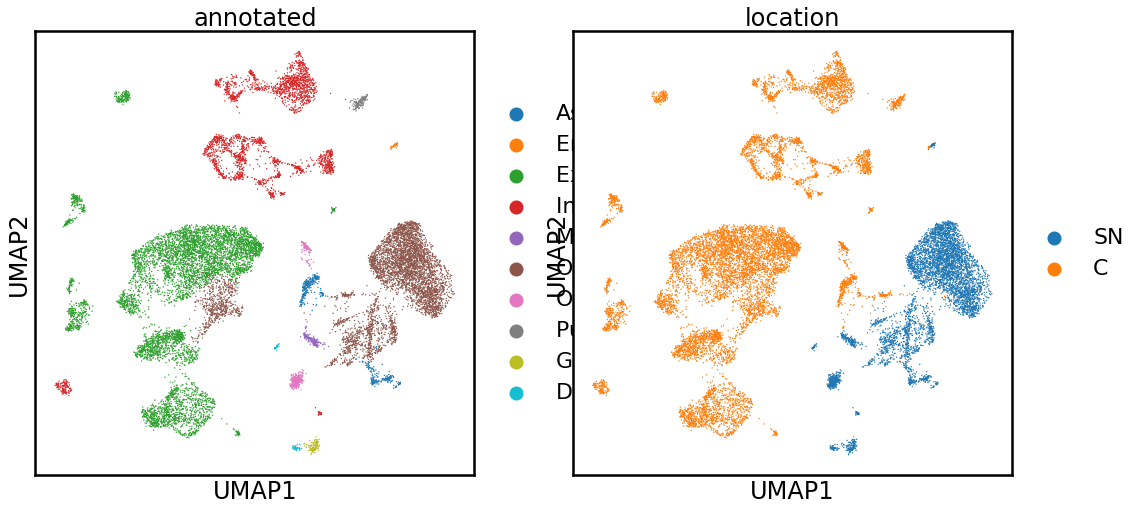

In [15]:
sc.pl.umap(adata, color=['annotated', 'location'])

Prepare test data.

In [16]:
#select astrocytes
adata_astro = adata[adata.obs['annotated'] == 'Astrocyte'].copy() 

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata_astro.obs['location'].value_counts()

C     264
SN    197
Name: location, dtype: int64

In [18]:
adata_astro

AnnData object with n_obs × n_vars = 461 × 23988
    obs: 'batch', 'donor', 'location', 'replicate', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'doublet', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1.5', 'louvain_r0.5', 'annotated', 'DAN_r'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'DAN_r_colors', 'annotated_colors', 'astro', 'batch_colors', 'diffmap_evals', 'donor_colors', 'draw_graph', 'location_colors', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_r0.5', 'rank_genes_r1.5', 'replicate_colors', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_emb', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Run the test on the count data. It must be noted that the `counts` layer does not contain the sample description nor gene names.

In [19]:
test = de.test.wald(
    data=adata_astro.layers['counts'],
    formula_loc="~ 1 + location",
    factor_loc_totest="location",
    gene_names=adata_astro.var_names,
    sample_description=adata_astro.obs
)

training location model: False
training scale model: True
iter   0: ll=34432734.665221
iter   1: ll=34432734.665221, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=2493324.986490, converged: 12.84% (loc: 12.84%, scale update: True), in 197.53sec
iter   3: ll=2493324.986490, converged: 12.84% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=2263597.053165, converged: 71.59% (loc: 71.59%, scale update: True), in 157.32sec
iter   5: ll=2263597.053165, converged: 71.59% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=2234232.833737, converged: 91.07% (loc: 91.07%, scale update: True), in 63.60sec
iter   7: ll=2234232.833737, converged: 91.07% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=2228020.932705, converged: 98.19% (loc: 98.19%, scale update: True), in 31.83sec
iter   9: ll=2228020.932705, converged: 98.19% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=2227632.040597, converged: 99.74% (loc: 99.74%,

/opt/python/lib/python3.8/site-packages/dask/array/core.py:2821: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


Obtain results.


`test.summary()` returns a `pandas` `DataFrame` with a quick overview of the test results.

In [20]:
#view first 10 results
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,RP11-34P13.3,1.000000,1.000000,-1.277361e-13,0.000000,True,4.661331e-130,-1.277361e-13,6.103423e+63,-1.520688e-127
1,RP11-34P13.7,0.000000,0.000000,-2.977760e+02,0.006508,False,6.614951e-10,-2.977760e+02,2.222759e-162,-1.320247e+01
2,FO538757.2,0.047386,0.155946,4.462113e-01,0.214751,False,6.671758e-10,4.462113e-01,2.250368e-01,-2.588135e+02
3,AP006222.2,0.727419,1.000000,-1.385947e-01,0.056399,False,1.051842e-10,-1.385947e-01,3.976202e-01,-1.013451e+02
4,RP4-669L17.10,0.817416,1.000000,4.004018e-01,0.006508,False,9.813933e-11,4.004018e-01,1.734314e+00,-1.488392e+01
5,RP5-857K21.4,0.004530,0.019713,5.381855e-01,0.314534,False,2.047767e-09,5.381855e-01,1.895919e-01,-3.279572e+02
6,RP5-857K21.2,0.000000,0.000000,2.839131e+02,0.004338,False,8.725527e-03,2.839131e+02,2.222759e-162,-2.767136e+01
7,RP11-206L10.9,0.469621,0.777125,3.358633e-01,0.049892,False,4.799018e-10,3.358633e-01,4.644795e-01,-9.193744e+01
8,FAM41C,1.000000,1.000000,-1.277361e-13,0.000000,True,4.661331e-130,-1.277361e-13,6.103423e+63,-1.520688e-127
9,RP11-54O7.3,0.000000,0.000000,-2.977760e+02,0.008677,False,2.197961e-02,-2.977760e+02,2.222759e-162,0.000000e+00


Table column description:
* gene: gene name / identifier
* pval: p-value of the gene
* qval: multiple testing - corrected p-value of the gene
* log2fc: log_2 fold change between no coefficient and coefficient
* grad: the gradient of the gene's log-likelihood
* coef_mle the maximum-likelihood estimate of the coefficient in liker-space
* coef_sd the standard deviation of the coefficient in liker-space
* ll: the log-likelihood of the estimation

Order test results by q-value:

In [21]:
test.summary().sort_values('qval').iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
18593,TRIM72,0.0,0.0,283.913085,0.002169,False,6.327799e-03,283.913085,2.222759e-162,-1.127477
11448,RP11-953B20.1,0.0,0.0,283.913085,0.002169,False,6.474590e-03,283.913085,2.222759e-162,-8.505483
4953,RP11-167H9.5,0.0,0.0,283.913085,0.002169,False,4.337303e-03,283.913085,2.222759e-162,-13.863195
19075,RP11-863P13.3,0.0,0.0,-297.776029,0.002169,False,1.696100e-07,-297.776029,2.222759e-162,-6.283128
4951,RP11-651P23.5,0.0,0.0,283.913085,0.002169,False,5.345893e-03,283.913085,2.222759e-162,-12.838208
20639,TMEM241,0.0,0.0,1.150119,2.145336,False,1.414436e-09,1.150119,1.275547e-01,-863.277451
20638,CABLES1,0.0,0.0,1.102192,1.572668,False,9.836432e-10,1.102192,1.247507e-01,-755.397158
17025,CTD-3035D6.2,0.0,0.0,-297.776029,0.002169,False,1.938795e-03,-297.776029,2.222759e-162,-0.115954
4941,RP11-206M11.7,0.0,0.0,-297.776029,0.002169,False,1.955819e-03,-297.776029,2.222759e-162,-5.215814
14968,RP11-996F15.6,0.0,0.0,-297.776029,0.002169,False,2.581293e-03,-297.776029,2.222759e-162,0.000000


`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

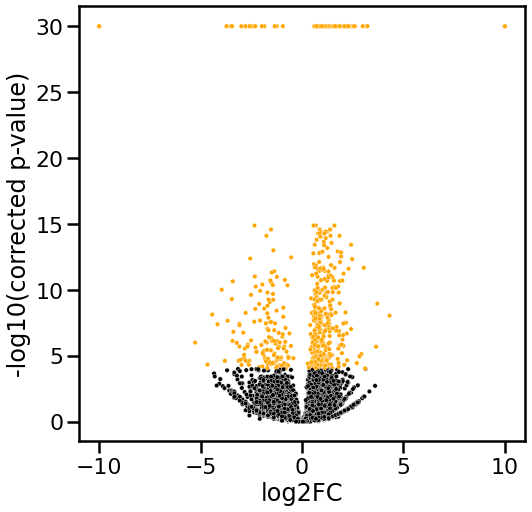

In [22]:
test.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=10e-5, size=20)

Save results to file.

In [ ]:
test.summary().to_csv(table_dir + 'test_astrocytes.csv')

**Comment:** Apart from Wald tests, `diffxpy` provides the following hypothesis tests: 
* Welch's t-test (see `de.test.t_test()`) 
* Rank sum test (see `de.test.rank_test()`)
* Likelihood-ratio test (LRT) (see `de.test.lrt()`)

**Tasks:** 
* Extract the significant differentially expressed genes from the `test.summary()` table and split the list into higher expressed in cortex and higher expressed in substantia nigra. 
* Filter for a minimum mean expression of `0.05` (or choose your own threshold). 
* Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot. 

In [16]:
test_summary = pd.read_csv(table_dir + 'test_MB_astrocytes.csv', index_col=0)

In [17]:
test_summary

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,RP11-34P13.3,1.000000,1.000000,0.000000,0.000000,True,4.661331e-130,0.000000,6.103423e+63,-1.520688e-127
1,RP11-34P13.7,0.000000,0.000000,-297.776029,0.006508,False,1.906350e-10,-297.776029,2.222759e-162,-1.320247e+01
2,FO538757.2,0.047386,0.155946,0.446211,0.214751,False,6.683640e-10,0.446211,2.250368e-01,-2.588135e+02
3,AP006222.2,0.727419,1.000000,-0.138595,0.056399,False,4.578814e-11,-0.138595,3.976202e-01,-1.013451e+02
4,RP4-669L17.10,0.817416,1.000000,0.400402,0.006508,False,9.817744e-11,0.400402,1.734314e+00,-1.488392e+01
...,...,...,...,...,...,...,...,...,...,...
23983,AC007325.4,0.762739,1.000000,-0.174962,0.036876,False,2.296799e-09,-0.174962,5.795644e-01,-7.049450e+01
23984,AC007325.2,0.028752,0.101891,0.939398,0.067245,False,3.576053e-03,0.939398,4.295623e-01,-1.109582e+02
23985,AL354822.1,0.836008,1.000000,-0.292745,0.004338,False,2.408608e-01,-0.292745,1.414214e+00,-1.058014e+01
23986,AC004556.1,0.000000,0.000000,283.913085,0.004338,False,9.890485e-03,283.913085,2.222759e-162,-2.537550e+01


In [18]:
test_signif = test_summary.loc[test_summary['qval']<0.05]

In [19]:
test_pos = test_signif.loc[test_signif['log2fc']>0]
test_neg = test_signif.loc[test_signif['log2fc']<0]

In [29]:
test_pos.sort_values('mean', ascending=False).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
13058,MALAT1,0.000503,0.002471,0.228878,221.542299,False,5.365453e-08,0.228878,0.065784,-2892.031738
4688,LSAMP,0.000000,0.000000,0.912906,12.885033,False,3.616529e-08,0.912906,0.062723,-1538.054933
12757,SLC1A2,0.000000,0.000000,2.203052,12.789588,False,2.698498e-08,2.203052,0.083009,-1443.344822
2908,CTNNA2,0.000000,0.000000,1.422662,10.741866,False,2.815208e-10,1.422662,0.068785,-1422.336058
16228,PCDH9,0.000000,0.000000,0.725401,10.184382,False,3.234452e-08,0.725401,0.061344,-1437.505491
6226,GPM6A,0.000000,0.000000,1.392302,9.887202,False,3.329948e-08,1.392302,0.066546,-1380.405775
16576,NPAS3,0.000000,0.000000,0.631609,8.865510,False,1.400052e-08,0.631609,0.057632,-1362.569414
16288,GPC5,0.000000,0.000000,1.067615,8.403471,False,6.611931e-09,1.067615,0.075537,-1381.994325
2702,NRXN1,0.000000,0.000000,1.311811,7.984816,False,2.879493e-09,1.311811,0.072227,-1323.768776
17576,RORA,0.000000,0.000000,0.722579,7.553145,False,5.116238e-08,0.722579,0.067860,-1332.982006


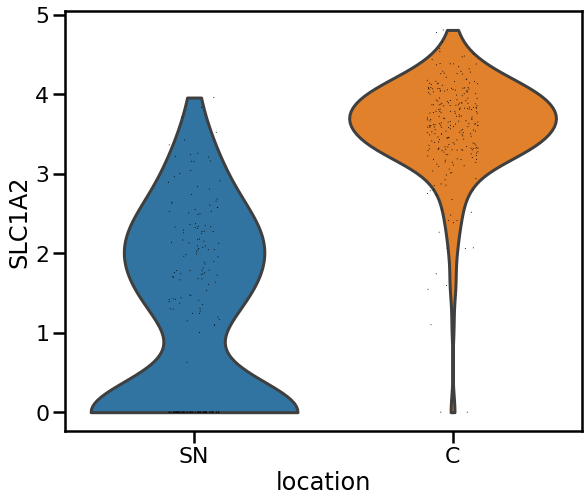

In [24]:
sc.pl.violin(adata_astro, groupby='location', keys='SLC1A2')

**Task:** Save your filtered tables to file.

## Include continuous covariates

In the previous test, we did not consider cell-specific effects in the test. 
However, the count data is not normalised and size factors indicate cell-specific differences in e.g. cell size and sequencing depth. Therefore, we use it as additional, numeric covariate to regress out the effect described by the size factors.  

Firstly, you have to indicate that you are supplying a continuous effect if you want to do so. We will otherwise turn it into a categorical effect and this will not produce the desired results. We do this so that we can make sure that there are no errors arising from numeric and categorical columns in `pandas` `DataFrames`. 

**Please note** that the following differential expression tests **takes considerably longer than the simple test above** because it optimizes more parameters.

In [ ]:
test_sf = de.test.wald(
    data=adata_astro.layers['counts'],
    formula_loc="~ 1 + location + size_factors",
    factor_loc_totest="location",
    as_numeric=['size_factors'],
    gene_names=adata_astro.var_names,
    sample_description=adata_astro.obs
)


The results can be retrieved as before. Please note that the results differ now as we imposed size factors without changing the data:

In [ ]:
sb.scatterplot(
    x=test.log10_pval_clean(),
    y=test_sf.log10_pval_clean()
)
plt.show()

Order test results by q-value:

In [ ]:
test_sf.summary().sort_values('qval', ascending=True).iloc[:10,:]

In [ ]:
test_sf.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=10e-5, size=20)

Save results to file.

In [ ]:
test_sf.summary().to_csv(table_dir + 'test_sf.csv')

# Test multiple coefficients with a Wald test

We now turn to tests that cannot be performed with t-tests or rank sum tests because they involve more than two groups (or more general: multiple coefficients). 
Here, we cover two different test scenarios, where we first test in general for donor-specific differences and we second test a specific donor.
In our test case, we use look at donor-specific differences in dopaminergic neurons in the substantia nigra.

In [ ]:
adata_DN = adata[np.logical_and(adata.obs['annotated']=='Dopaminergic neuron',
                                adata.obs['location']=='SN')].copy()

In [ ]:
adata_DN.obs['donor'].value_counts()

## Test a whole factor

In [ ]:
test_fac = de.test.wald(
    data=adata_DN.layers['counts'],
    formula_loc="~ 1 + donor",
    factor_loc_totest="donor",
    gene_names=adata_DN.var_names,
    sample_description=adata_DN.obs
)

Look at the top 10 results.

In [ ]:
test_fac.summary().sort_values('qval').iloc[:10, :]

## Test selected coefficients

First, we preview the coefficient names and then yield the desired list to `diffxpy`.

In [ ]:
de.utils.preview_coef_names(
    sample_description=adata_DN.obs,
    formula="~ 1 + donor"
)

Second, set up the Wald test with the coefficient(s) of interest.

In [ ]:
test_coef = de.test.wald(
    data=adata_DN.layers['counts'],
    formula_loc="~ 1 + donor",
    coef_to_test=['donor[T.5]'],
    gene_names=adata_DN.var_names,
    sample_description=adata_DN.obs
)

Look at the top 10 results.

In [ ]:
test_coef.summary().sort_values('qval').iloc[:10, :]

Save results to file.

In [ ]:
test_coef.summary().to_csv(table_dir + 'test_coef.csv')

# Further scenarios

Was your scenario not captured by any of these classes of tests? diffxpy wraps a number of further advanced tests to which we dedicated separate tutorials of the `diffxpy` package. These are:

* pairwise tests between groups ("multiple_tests_per_gene")
* groupwise tests versus all other groups ("multiple_tests_per_gene")
* modelling continuous covariates such as as total counts, time, pseudotime, space, concentration ("modelling_continuous_covariates")
* modelling equality constraints, relevant for scenarios with perfect confounding ("modelling_constraints")